In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import cv2
from scipy.spatial import distance

Using TensorFlow backend.


#### Get data from the database

In [2]:
mask_path = "./Resources/Train/WithMask"
no_mask_path = "./Resources/Train/WithoutMask"

In [39]:
def create_resultArray(path,label):
    result =[]
    target =[]
    #Append iamge and labels to the list form the directory
    for i in os.listdir(path):
        pic = os.path.join(path + "/", i)
        result.append(pic)
        target.append(label)   
    return result , target

mask_list , mask_target = create_resultArray(mask_path , "with_mask")
no_mask_list, no_mask_target = create_resultArray(no_mask_path , "without_mask")

mask = pd.DataFrame()
mask["image"] = mask_list
mask["target"] = mask_target

no_mask = pd.DataFrame()
no_mask["image"] = no_mask_list
no_mask["target"] = no_mask_target

data = pd.concat([mask, no_mask], axis = 0, ignore_index = True)
data = shuffle(data)
data.to_csv("./Resources/mask_no_mask.csv", encoding="utf-8")

print("Total Images: ",data.shape[0])
data.head()

Total Images:  12219


,image,target
2885,./Resources/Train/WithMask/Augmented_500_32002...,with_mask
5491,./Resources/Train/WithoutMask/1 (1396).jpg,without_mask
10084,./Resources/Train/WithoutMask/1 (5439).jpg,without_mask
4554,./Resources/Train/WithMask/Augmented_81_743135...,with_mask
10543,./Resources/Train/WithoutMask/1 (5846).jpg,without_mask


#### Building MobileNetV2 transfer learning model.¶

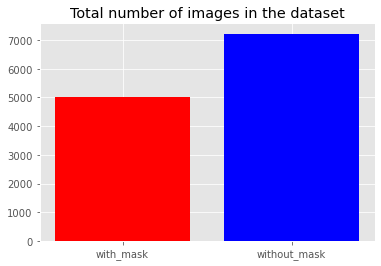

In [4]:
plt.style.use('ggplot')
group_data = data.groupby("target").count()
x= group_data.index
y = group_data["image"]
plt.bar(x,y , color=["r","b"])
plt.title("Total number of images in the dataset")
plt.savefig("./Images/barchart.jpg")
plt.show()


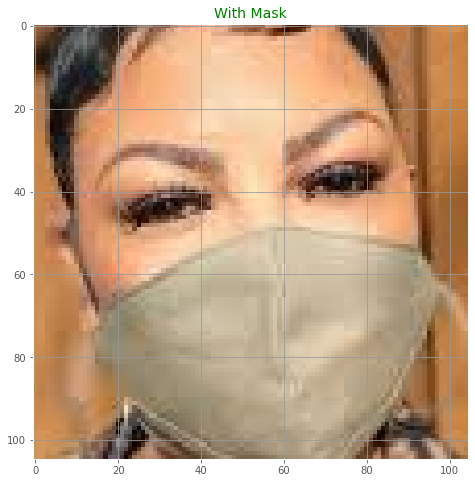

In [5]:
plt.figure(figsize=(12,8))

img = load_img(mask["image"][10])
plt.imshow(img)
plt.title("With Mask", color = "green", size = 14)
plt.grid(color='#999999', linestyle='-')
plt.show()

#### Prepare for data augmentation: 
    - ImageDataGenerator accepts the original data, randomly transforms it, and returns only the new, transformed data.

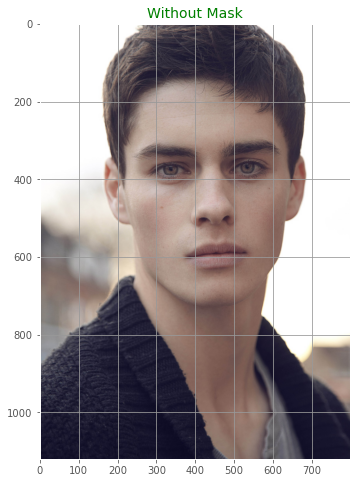

In [6]:
plt.figure(figsize=(12,8))

img = load_img(no_mask["image"][750])
plt.imshow(img)
plt.title("Without Mask", color = "green", size = 14)
plt.grid(color='#999999', linestyle='-')
plt.show()


In [7]:
train = data.iloc[0:10000, ]
val = data.iloc[10001:11001, ]
test = data.iloc[11002:, ]

In [8]:
print("Train Seti:","\n",train["target"].value_counts(),"\n""Validation Seti: ","\n", val["target"].value_counts(), "\n"
      "Test Seti: ", "\n",test["target"].value_counts())

Train Seti: 
 without_mask    5896
with_mask       4104
Name: target, dtype: int64 
Validation Seti:  
 without_mask    583
with_mask       417
Name: target, dtype: int64 
Test Seti:  
 without_mask    738
with_mask       479
Name: target, dtype: int64


In [9]:

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode = "nearest")

train_generator = train_datagen.flow_from_dataframe(dataframe = train,
                                                    x_col = "image",
                                                    y_col = "target",
                                                    target_size = (128, 128),
                                                    batch_size = 32,
                                                    class_mode = "binary")

val_datagen = ImageDataGenerator(rescale = 1./255)

val_generator = val_datagen.flow_from_dataframe(dataframe = val,
                                                x_col = "image",
                                                y_col = "target",
                                                target_size = (128, 128),
                                                batch_size = 32,
                                                class_mode = "binary")
test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_dataframe(dataframe = test,
                                                  x_col = "image",
                                                  y_col = "target",
                                                  target_size = (128, 128),
                                                  class_mode = "binary",
                                                  batch_size = 32)

Found 10000 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.
Found 1217 validated image filenames belonging to 2 classes.


In [10]:
from keras import layers
from keras import models
from keras import optimizers
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input

vgg19 = VGG19(weights='imagenet',include_top=False,input_shape=(128,128,3))

for layer in vgg19.layers:
    layer.trainable = False
    
model = models.Sequential()
model.add(vgg19)
model.add(layers.Flatten())
model.add(layers.Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 8193      
Total params: 20,032,577
Trainable params: 8,193
Non-trainable params: 20,024,384
_________________________________________________________________


compile and train our face mask detector network:

In [11]:
model.compile(loss = "binary_crossentropy",
             optimizer = optimizers.RMSprop(lr = 1e-4),
             metrics = ["acc"])

#### Evaluate the resulting model on the test set:

In [13]:
history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator)//32,
                    epochs=33,
                    validation_data=val_generator,
                    validation_steps=len(val_generator)//32                   
                   )


Epoch 1/33
8/9 [=========================>....] - ETA: 1s - loss: 0.7572 - acc: 0.5039

C:\Users\ubc\anaconda3\envs\maclearnpy\lib\site-packages\PIL\Image.py:952: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


9/9 [==============================] - 19s 2s/step - loss: 0.7515 - acc: 0.5104 - val_loss: 0.6661 - val_acc: 0.6250
Epoch 2/33
9/9 [==============================] - 19s 2s/step - loss: 0.6545 - acc: 0.5833 - val_loss: 0.6639 - val_acc: 0.5938
Epoch 3/33
9/9 [==============================] - 33s 4s/step - loss: 0.5947 - acc: 0.7188 - val_loss: 0.6849 - val_acc: 0.6562
Epoch 4/33
9/9 [==============================] - 41s 5s/step - loss: 0.5944 - acc: 0.6979 - val_loss: 0.5966 - val_acc: 0.6562
Epoch 5/33
9/9 [==============================] - 39s 4s/step - loss: 0.5663 - acc: 0.7569 - val_loss: 0.5009 - val_acc: 0.9062
Epoch 6/33
9/9 [==============================] - 42s 5s/step - loss: 0.5363 - acc: 0.8125 - val_loss: 0.4524 - val_acc: 0.8125
Epoch 7/33
9/9 [==============================] - 45s 5s/step - loss: 0.5316 - acc: 0.8160 - val_loss: 0.4723 - val_acc: 0.8438
Epoch 8/33
9/9 [==============================] - 47s 5s/step - loss: 0.4997 - acc: 0.8368 - val_loss: 0.4131 - val

### Plot loss and accuracy

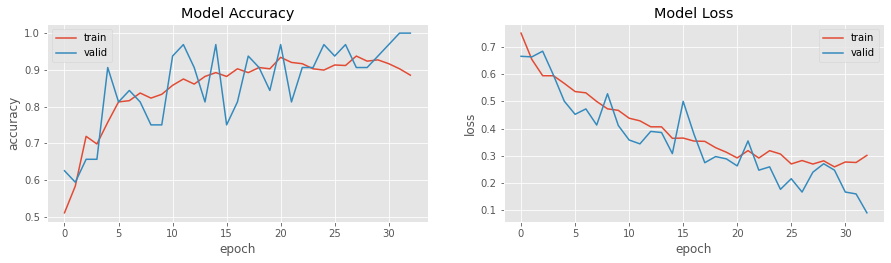

In [41]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc'])  
plt.title('Model Accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
plt.savefig("./images/model_accuracy.jpg")  

plt.subplot(222)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Model Loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
plt.savefig("./images/model_loss.jpg",bbox_inches='tight')  
plt.show()

#### Test Accuracy

In [24]:
test_loss, test_acc = model.evaluate(test_generator, steps = 5)
print("Test ACC: ", round(test_acc, 2))

5/5 [==============================] - 9s 2s/step
Test ACC:  0.92


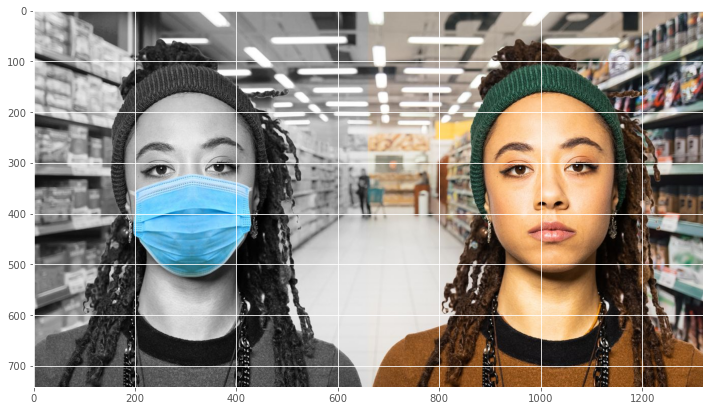

In [29]:
# test for realtime prediction

face_model = cv2.CascadeClassifier('./Resources/haarcascade_frontalface_default.xml')

img = cv2.imread('./Resources/Experiment/people1.jpg')

img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)

faces = face_model.detectMultiScale(img,scaleFactor=1.1, minNeighbors=4)


out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
# for (x,y,w,h) in faces:
#     cv2.rectangle(out_img,(x,y),(x+w,y+h),(0,0,255),1)
plt.figure(figsize=(12,12))
plt.imshow(out_img)

0.47728062
0.9979241


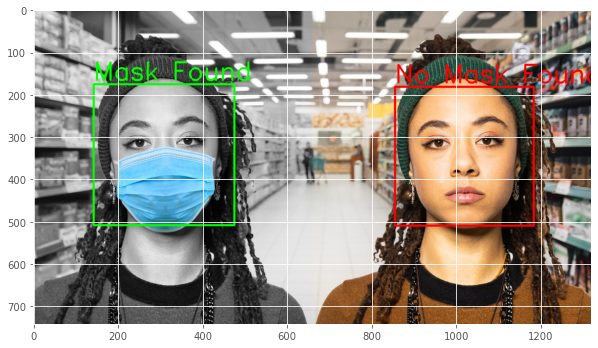

In [32]:
import matplotlib.pyplot as plt
mask_label = {0:'Mask Found',1:'No Mask Found'}
color_label = {0:(0,255,0),1:(255,0,0)}
MIN_DISTANCE = 0

img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)

faces = face_model.detectMultiScale(img,scaleFactor=1.1, minNeighbors=4)

#check for no. of faces in the image
# if more than one face found,
if len(faces)>=1:
    label = [0 for i in range(len(faces))]
    new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image
    
    # For every face found,  
    
    for i in range(len(faces)):
        (x,y,w,h) = faces[i]
        crop = new_img[y:y+h,x:x+w]
        crop = cv2.resize(crop,(128,128))
        crop = np.reshape(crop,[1,128,128,3])/255.0        
        mask_result = model.predict(crop)
        print(mask_result[0][0])
        
        cv2.putText(new_img,mask_label[round(mask_result[0][0])],(x, y-10), cv2.FONT_HERSHEY_SIMPLEX,2,color_label[round(mask_result[0][0])],3)
        cv2.rectangle(new_img,(x,y),(x+w,y+h), color_label[round(mask_result[0][0])],3)
        
    plt.figure(figsize=(10,10))
    plt.imshow(new_img)
            
else:
    print("No image")

In [33]:
model.save('./Saved_Model/keras_model.hdf5')